# 1.Data procession:

Data procession includes data loading and data transform. 
Our data loading function is in data_load.py
Our Transform.py loads the data by using loading function and transforms them into feature maps through VGG16, and return array finally.

In [11]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
import Transform
import model
import loss
%matplotlib inline
path="P:\kingsley\MSBD5001\data1\data\\"
X_train,X_val,X_test,y_train,y_val,y_test=Transform.transform(path)

#  2. Model building

Model building includes output, loss and optimization definition.

In [18]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 4, 4, 512])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = model.simple_model(X,y,is_training)
mean_loss,train_step=loss.loss(y_out,y)

# 3. Training model

In [19]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
        val_model(sess,y_out,mean_loss,X_val,y_val,1,120)
    return total_loss,total_correct

# 4. Validation part

In [20]:
def val_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    prediction=tf.cast(tf.argmax(predict,1),tf.float32)
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)
    training_now =False
    variables = [correct_prediction,prediction,accuracy]
    correct = 0
    idx = train_indicies[:batch_size]

    feed_dict = {X: Xd[idx,:], y: yd[idx], is_training: training_now }
    corr,prediction, _ = session.run(variables,feed_dict=feed_dict)
    correct += np.sum(corr)
    correct/=batch_size
    print("validation_accuracy:")
    print(correct)
    return prediction,idx

# 5. Result display

Training
Iteration 0: with minibatch training loss = 4.51 and accuracy of 0.036
Epoch 1, Overall loss = 1.95 and accuracy of 0.473


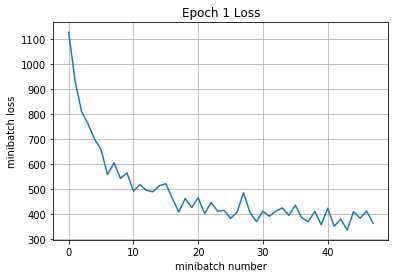

validation_accuracy:
0.375
Epoch 2, Overall loss = 0.66 and accuracy of 0.83


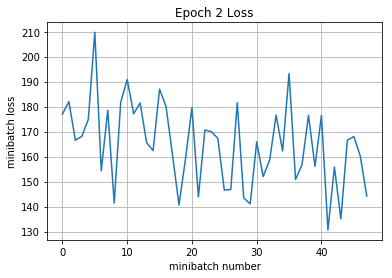

validation_accuracy:
0.4666666666666667
Iteration 100: with minibatch training loss = 0.327 and accuracy of 0.94
Epoch 3, Overall loss = 0.244 and accuracy of 0.96


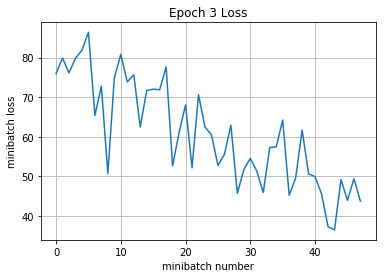

validation_accuracy:
0.49166666666666664
Epoch 4, Overall loss = 0.0923 and accuracy of 0.991


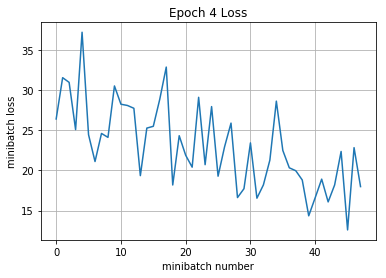

validation_accuracy:
0.6083333333333333
Iteration 200: with minibatch training loss = 0.0452 and accuracy of 1
Epoch 5, Overall loss = 0.054 and accuracy of 0.995


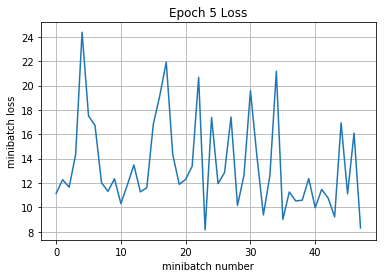

validation_accuracy:
0.5916666666666667
Epoch 6, Overall loss = 0.0312 and accuracy of 0.997


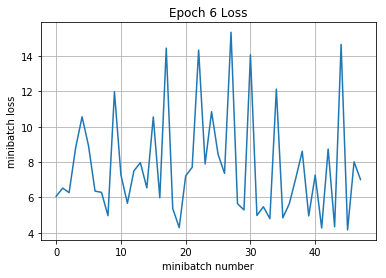

validation_accuracy:
0.65
Iteration 300: with minibatch training loss = 0.0144 and accuracy of 1
Epoch 7, Overall loss = 0.0215 and accuracy of 0.998


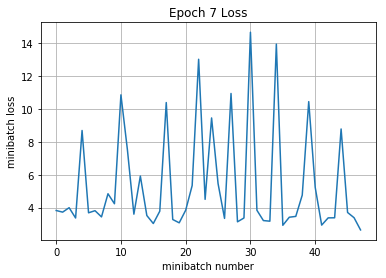

validation_accuracy:
0.6666666666666666
Validation
validation_accuracy:
0.64


In [27]:
with tf.Session() as sess:
    with tf.device("/gpu:0"): 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,7,250,100,train_step,True)
        print('Validation')
        predict,idx=val_model(sess,y_out,mean_loss,X_val,y_val,1,100)

# 6. Result Mapping

In [31]:
def mapping(arr):
    result = np.zeros(real_label.shape[0],)
    for i in range(real_label.shape[0]):
        if arr[i] <= 5:
            result[i] = 0
        elif arr[i] <= 13:
            result[i] = 1
        elif arr[i] <= 36:
            result[i] = 2
        else:
            result[i] = 3
    return result
real_label = y_val[idx]
map_real = mapping(real_label)
map_predict = mapping(predict)
print("validation accuracys:", (map_real == map_predict).sum()/real_label.shape[0])

validation accuracys: 0.89
